In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_score, mean_absolute_error, classification_report
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

In [6]:
data = pd.read_csv('Climate_SPI.csv')
data['Drought'] = np.where(data['SPI'] <= -1, 1, 0)

# Define predictors and target variables
predictors = ['mn2t', 'msl', 'mx2t', 'q', 't', 't2', 'tcc', 'u', 'u10', 'v', 'v10', 'z']
X = data[predictors]
y_classification = data['Drought']
y_regression = data['SPI']

In [7]:
X_train_class, X_temp_class, y_train_class, y_temp_class = train_test_split(X, y_classification, test_size=0.3, random_state=42)
X_val_class, X_test_class, y_val_class, y_test_class = train_test_split(X_temp_class, y_temp_class, test_size=0.5, random_state=42)

X_train_reg, X_temp_reg, y_train_reg, y_temp_reg = train_test_split(X, y_regression, test_size=0.3, random_state=42)
X_val_reg, X_test_reg, y_val_reg, y_test_reg = train_test_split(X_temp_reg, y_temp_reg, test_size=0.5, random_state=42)


In [8]:
scaler = StandardScaler()

# Scale data for classification
X_train_class_scaled = scaler.fit_transform(X_train_class)
X_val_class_scaled = scaler.transform(X_val_class)
X_test_class_scaled = scaler.transform(X_test_class)

# Scale data for regression
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_val_reg_scaled = scaler.transform(X_val_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)


In [9]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=0.00001
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [10]:
classification_model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train_class_scaled.shape[1],)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

classification_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002), loss='binary_crossentropy', metrics=['accuracy'])

history_classification = classification_model.fit(
    X_train_class_scaled, y_train_class,
    epochs=100,
    validation_data=(X_val_class_scaled, y_val_class),
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)


C:\Users\krlee\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8318 - loss: 0.4152 - val_accuracy: 0.8616 - val_loss: 0.3181 - learning_rate: 0.0020
Epoch 2/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8523 - loss: 0.3502 - val_accuracy: 0.8589 - val_loss: 0.3164 - learning_rate: 0.0020
Epoch 3/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8591 - loss: 0.3284 - val_accuracy: 0.8713 - val_loss: 0.3073 - learning_rate: 0.0020
Epoch 4/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8592 - loss: 0.3399 - val_accuracy: 0.8682 - val_loss: 0.3104 - learning_rate: 0.0020
Epoch 5/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8639 - loss: 0.3204 - val_accuracy: 0.8638 - val_loss: 0.3140 - learning_rate: 0.0020
Epoch 6/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8620 - loss: 0.3175 - val_accuracy: 0.8677 - val_loss: 0.3069 - learning_rate: 0.0020
Epoch 7/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8602 - loss: 0.

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(history_classification.history['accuracy'], label='Training Accuracy')
plt.plot(history_classification.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Classification Model Accuracy')
plt.legend()
plt.savefig('Classification_Model_Accuracy_Improved.png')
plt.show()


NameError: name 'plt' is not defined

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


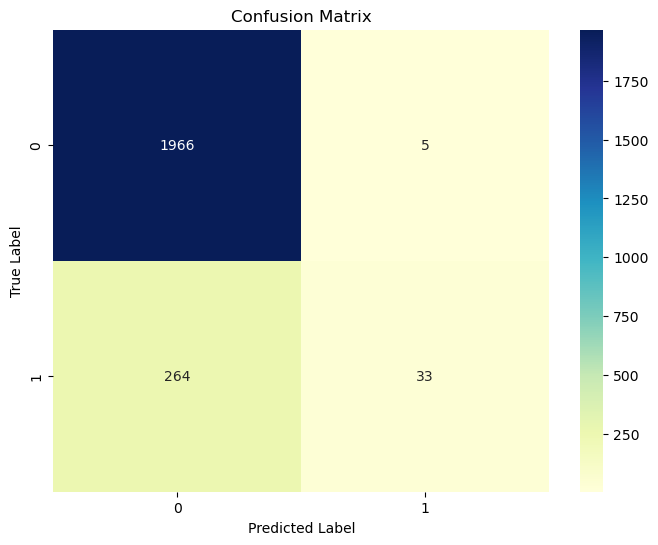

Confusion Matrix:
 [[1966    5]
 [ 264   33]]
Balanced Accuracy: 0.5542871638762049
Precision: 0.868421052631579
Weighted Average Accuracy: 0.8798866561021388


In [8]:
threshold = 0.8
y_pred_class = (classification_model.predict(X_test_class_scaled) > threshold).astype(int)

conf_matrix = confusion_matrix(y_test_class, y_pred_class)
balanced_acc = balanced_accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report
report = classification_report(y_test_class, y_pred_class, output_dict=True)
weighted_avg_accuracy = report['weighted avg']['precision']

print("Confusion Matrix:\n", conf_matrix)
print("Balanced Accuracy:", balanced_acc)
print("Precision:", precision)
print("Weighted Average Accuracy:", weighted_avg_accuracy)


In [9]:
regression_model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train_reg_scaled.shape[1],), kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])

regression_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history_regression = regression_model.fit(
    X_train_reg_scaled, y_train_reg,
    epochs=100,
    validation_data=(X_val_reg_scaled, y_val_reg),
    batch_size=16,
    callbacks=[early_stopping, lr_scheduler]
)


C:\Users\krlee\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 1.0982 - mae: 0.7699 - val_loss: 0.7761 - val_mae: 0.6369 - learning_rate: 0.0010
Epoch 2/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.8255 - mae: 0.6590 - val_loss: 0.7237 - val_mae: 0.6193 - learning_rate: 0.0010
Epoch 3/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.7519 - mae: 0.6380 - val_loss: 0.6194 - val_mae: 0.5730 - learning_rate: 0.0010
Epoch 4/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7246 - mae: 0.6312 - val_loss: 0.6013 - val_mae: 0.5699 - learning_rate: 0.0010
Epoch 5/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6740 - mae: 0.6122 - val_loss: 0.5574 - val_mae: 0.5526 - learning_rate: 0.0010
Epoch 6/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6642 - mae: 0.6143 - val_loss: 0.5427 - val_mae: 0.5495 - learning_rate: 0.0010
Epoch 7/100
662/662 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6371 - mae: 0.6051 - val_loss: 0.5372 - val_mae: 0.5491 - learning_rat

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(history_regression.history['loss'], label='Training Loss')
plt.plot(history_regression.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Regression Model Loss')
plt.legend()
plt.savefig('Regression_Model_Loss_Improved.png')
plt.show()


NameError: name 'history_regression' is not defined

<Figure size 1000x600 with 0 Axes>

In [19]:
y_pred_reg = regression_model.predict(X_test_reg_scaled).flatten()
mae = mean_absolute_error(y_test_reg, y_pred_reg)
pearson_corr, _ = pearsonr(y_test_reg, y_pred_reg)

# Scatter Plot for True vs Predicted SPI
plt.figure(figsize=(6, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.xlabel('True SPI')
plt.ylabel('Predicted SPI')
plt.title('True vs Predicted SPI')
plt.savefig('True_vs_Predicted_Improved.png')
plt.show()

print("Mean Absolute Error (MAE):", mae)
print("Pearson Correlation Coefficient:", pearson_corr)


NameError: name 'regression_model' is not defined

In [219]:
classification_model.save('class_model_mark10.keras')

In [221]:
regression_model.save('regression_model_mark10.keras')

In [223]:
regression_model = load_model('regression_model_mark10.keras')

In [1]:
y_pred_reg = regression_model.predict(X_test_reg_scaled).flatten()
mae = mean_absolute_error(y_test_reg, y_pred_reg)
pearson_corr, _ = pearsonr(y_test_reg, y_pred_reg)

# Scatter plot of true vs predicted SPI values
plt.figure(figsize=(7, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.xlabel('True SPI')
plt.ylabel('Predicted SPI')
plt.title('True vs Predicted SPI')
plt.savefig('True_vs_Predicted_Improved.png')
plt.show()

print("Mean Absolute Error (MAE):", mae)
print("Pearson Correlation Coefficient:", pearson_corr)


NameError: name 'regression_model' is not defined

In [227]:
classification_model = load_model('class_model_mark10.keras')

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


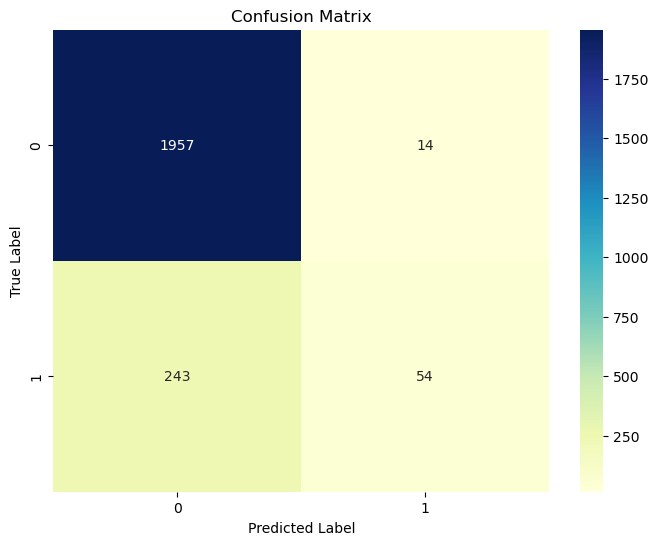

Confusion Matrix:
 [[1957   14]
 [ 243   54]]
Balanced Accuracy: 0.5873575942069093
Precision: 0.7941176470588235
Weighted Average Accuracy: 0.8770489559460147


In [229]:
y_pred_class = (classification_model.predict(X_test_class_scaled) > threshold).astype(int)
conf_matrix = confusion_matrix(y_test_class, y_pred_class)
balanced_acc = balanced_accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Calculate weighted average accuracy
report = classification_report(y_test_class, y_pred_class, output_dict=True)
weighted_avg_accuracy = report['weighted avg']['precision']

print("Confusion Matrix:\n", conf_matrix)
print("Balanced Accuracy:", balanced_acc)
print("Precision:", precision)
print("Weighted Average Accuracy:", weighted_avg_accuracy)


In [23]:
from tensorflow.keras.models import load_model

# Load the saved models
classification_model = load_model('class_model_mark10.keras')
regression_model = load_model('regression_model_mark10.keras')

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


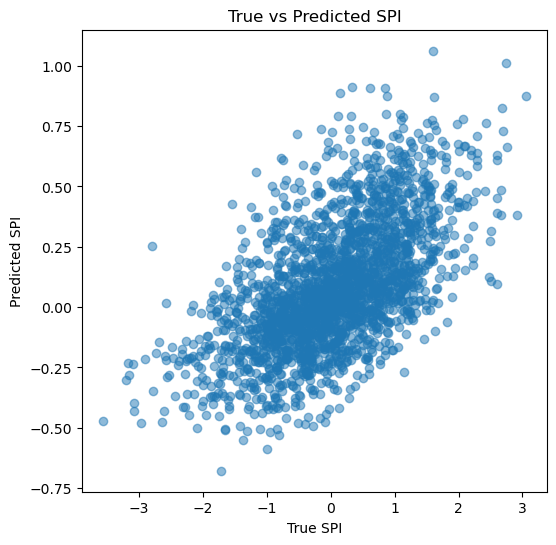

Mean Absolute Error (MAE): 0.6618062130329199
Pearson Correlation Coefficient: 0.5942564551589715


In [25]:
# Make predictions with the loaded regression model
y_pred_reg = regression_model.predict(X_test_reg_scaled).flatten()

# Calculate metrics
mae = mean_absolute_error(y_test_reg, y_pred_reg)
pearson_corr, _ = pearsonr(y_test_reg, y_pred_reg)

# Scatter plot for true vs predicted SPI values
plt.figure(figsize=(6, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.xlabel('True SPI')
plt.ylabel('Predicted SPI')
plt.title('True vs Predicted SPI')
plt.savefig('True_vs_Predicted_Improved.png')
plt.show()

print("Mean Absolute Error (MAE):", mae)
print("Pearson Correlation Coefficient:", pearson_corr)


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


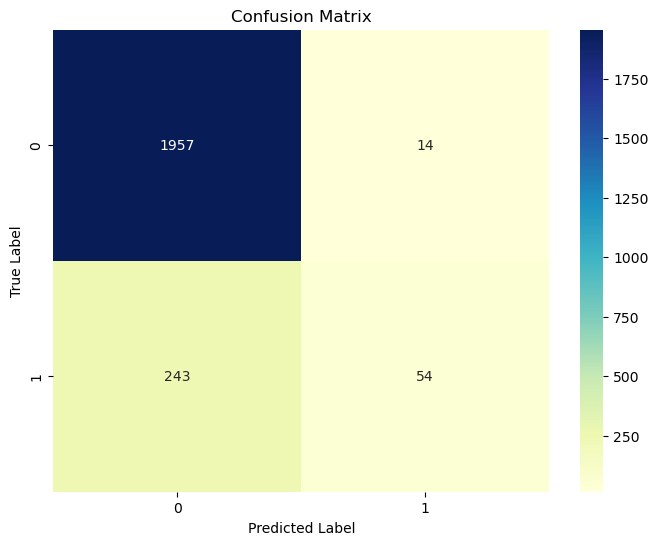

Confusion Matrix:
 [[1957   14]
 [ 243   54]]
Balanced Accuracy: 0.5873575942069093
Precision: 0.7941176470588235
Weighted Average Accuracy: 0.8770489559460147


In [27]:
# Set threshold for binary predictions
threshold = 0.8

# Make predictions with the loaded classification model
y_pred_class = (classification_model.predict(X_test_class_scaled) > threshold).astype(int)

# Compute confusion matrix and metrics
conf_matrix = confusion_matrix(y_test_class, y_pred_class)
balanced_acc = balanced_accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Generate classification report and extract weighted average accuracy
report = classification_report(y_test_class, y_pred_class, output_dict=True)
weighted_avg_accuracy = report['weighted avg']['precision']

print("Confusion Matrix:\n", conf_matrix)
print("Balanced Accuracy:", balanced_acc)
print("Precision:", precision)
print("Weighted Average Accuracy:", weighted_avg_accuracy)
